In [1]:
!source /etc/network_turbo
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

设置成功
注意：仅限于学术用途，不承诺稳定性保证



# 🎓 Entropy-based Data Selection & LoRA Fine-tuning

This assignment focuses on **entropy-guided sample selection** and **LoRA fine-tuning**.

- **Model:** `NousResearch/Llama-3.2-1B`
- **Dataset:** `vicgalle/alpaca-gpt4`
- **Selection pool:** first **5,000** samples → `train[:5000]`
- **Evaluation set:** fixed **50** samples → `train[5000:5050]`

## Learning objectives
1. Compute **cross-entropy** per example (as an entropy proxy).
2. Design your own **entropy-based selection** of 1,000 samples.
3. Fine-tune a **LoRA adapter** on your selected data.
4. Evaluate with **ROUGE** and **visualize** base vs fine-tuned performance.

After finishing this assignment, you will understand:
1. How to measure data difficulty using model uncertainty.
2. How sample selection affects downstream fine-tuning.
3. How to conduct a controlled LoRA fine-tuning experiment.
4. How to evaluate instruction-tuned models with ROUGE metrics.


## Pipeline
1) Compute entropy on the 5k pool  
2) Implement your **selection** (1k)  
3) Fine-tune **one** LoRA adapter on your subset  
4) Evaluate **Base** and **Your-LoRA** on the fixed 50 (ROUGE)  
5) Plot the **ROUGE-L** comparison

## There are 4 Assignments (A1–A4) in this notebook:
1. **Assignment 1:** Implement token-level cross-entropy computation
2. **Assignment 2:** Implement sample selection strategy
3. **Assignment 3:** Train two LoRA adapters (Random vs Your Strategy)
4. **Assignment 4:** Plot ROUGE-L results to analyze outcomes


## 0. Setup

In [2]:

!pip -q install "transformers>=4.44.0" "datasets>=2.19.0" "accelerate>=0.33.0"                  "peft>=0.11.0" "trl>=0.9.6" bitsandbytes "evaluate>=0.4.2"                  sentencepiece tqdm jsonlines rouge-score matplotlib

import os, json, copy, gc, random
from dataclasses import dataclass
from typing import List, Dict, Any, Tuple
import torch
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import evaluate

from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training
from trl import SFTTrainer, SFTConfig

# Disable W&B
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"
os.environ["WANDB_SILENT"] = "true"
os.environ["WANDB_API_KEY"] = "disabled"
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "1"

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"
device


Torch: 2.8.0+cu128
CUDA available: True


'cuda'

## 1. Configuration

This section sets up the **experiment configuration** used throughout the notebook.  
We specify the base model, dataset slices, and key training parameters.

- **Base model:** `NousResearch/Llama-3.2-1B`  
- **Dataset:** `vicgalle/alpaca-gpt4` (using first 5k samples for selection, 50 for eval)
- **Goal:** fine-tune a LoRA adapter on 1k selected samples based on entropy scores.

### Key fields
| Parameter | Description |
|------------|-------------|
| `base_model` | Pretrained model checkpoint. |
| `pool_slice`, `eval_slice` | Subsets for scoring and evaluation. |
| `select_k` | Number of samples to select (e.g., 1000). |
| `learning_rate`, `num_train_epochs` | Training schedule parameters. |
| `lora_r`, `lora_alpha`, `lora_dropout` | LoRA adapter hyperparameters. |
| `target_modules` | Transformer layers where LoRA is applied. |



In [3]:

@dataclass
class CFG:
    base_model: str = "./NousResearch/Llama-3.2-1B"
    max_length: int = 2048

    dataset_name: str = "./vicgalle___alpaca-gpt4/default/0.0.0"
    pool_slice: str = "train[:5000]"
    eval_slice: str = "train[5000:5050]"

    select_k: int = 1000
    random_seed: int = 42  # only for any optional tie-breaking if you want
    # LoRA / training
    per_device_train_batch_size: int = 2
    gradient_accumulation_steps: int = 8
    learning_rate: float = 2e-4
    num_train_epochs: float = 1.0
    max_steps: int = -1
    logging_steps: int = 10
    save_steps: int = 250
    warmup_ratio: float = 0.03

    lora_r: int = 16
    lora_alpha: int = 32
    lora_dropout: float = 0.05
    target_modules: tuple = ("q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj")

    out_dir_student: str = "llama32_1b_alpaca_gpt4_student1k"

cfg = CFG()
cfg


CFG(base_model='./NousResearch/Llama-3.2-1B', max_length=2048, dataset_name='./vicgalle___alpaca-gpt4/default/0.0.0', pool_slice='train[:5000]', eval_slice='train[5000:5050]', select_k=1000, random_seed=42, per_device_train_batch_size=2, gradient_accumulation_steps=8, learning_rate=0.0002, num_train_epochs=1.0, max_steps=-1, logging_steps=10, save_steps=250, warmup_ratio=0.03, lora_r=16, lora_alpha=32, lora_dropout=0.05, target_modules=('q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj'), out_dir_student='llama32_1b_alpaca_gpt4_student1k')

## 2. Load Dataset and Map to OpenAI Message Format

This step loads the **Alpaca-GPT4** dataset and converts each example into the  
**OpenAI chat message format**, which uses a list of `{role, content}` pairs.

Each record from the dataset contains:
- `instruction`: the main user query  
- `input`: optional additional context  
- `output`: the assistant’s response

We reformat them as:
```python
[
    {"role": "user", "content": "..."},
    {"role": "assistant", "content": "..."}
]


In [4]:

def load_openai_messages_from_vicgalle(slice_str: str) -> List[Dict[str, Any]]:
    ds = load_dataset(cfg.dataset_name, split=slice_str)
    rows = []
    for i, row in enumerate(ds):
        instr = (row.get("instruction") or "").strip()
        inp = (row.get("input") or "").strip()
        out = (row.get("output") or "").strip()
        if not instr and not inp:
            continue
        user_msg = instr if instr else ""
        if inp:
            user_msg = (user_msg + ("\n\nInput:\n" if user_msg else "Input:\n")) + inp
        messages = [
            {"role":"user","content": user_msg},
            {"role":"assistant","content": out}
        ]
        rows.append({"id": i, "messages": messages})
    return rows

pool_data = load_openai_messages_from_vicgalle(cfg.pool_slice)
eval_data = load_openai_messages_from_vicgalle(cfg.eval_slice)
len(pool_data), len(eval_data)


(5000, 50)

## 3. Prompt Template and Helpers

This section defines how each conversation example is turned into a **prompt–response pair**  
that can be fed into the language model.

### Purpose
- Combine multiple chat messages (`system`, `user`, `assistant`) into one string prompt.  
- Extract the **final assistant answer** as the training target.

### Structure
The template `PROMPT_RAW` controls how text is formatted:
```python
{
  "system": "SYSTEM: {system}\n",
  "user": "\nHuman: {query}\nAssistant: ",
  "ass": "{response}"
}


In [5]:

PROMPT_RAW = {
    "system": "SYSTEM: {system}\n",
    "user": "\nHuman: {query}\nAssistant: ",
    "ass": "{response}"
}

def build_pair_from_openai_messages(messages: List[Dict[str, str]]) -> Tuple[str, str]:
    assert isinstance(messages, list) and len(messages) >= 2
    last_ass_idx = None
    for idx in range(len(messages)-1, -1, -1):
        if messages[idx].get("role") == "assistant":
            last_ass_idx = idx
            break
    assert last_ass_idx is not None and last_ass_idx >= 1

    parts = []
    for i in range(0, last_ass_idx):
        m = messages[i]
        role = m.get("role","")
        content = (m.get("content") or "").strip()
        if role == "system" and content:
            parts.append(PROMPT_RAW["system"].format(system=content))
        elif role == "user":
            parts.append(PROMPT_RAW["user"].format(query=content))
        elif role == "assistant":
            parts.append(PROMPT_RAW["ass"].format(response=content))
    context_str = "".join(parts).strip()
    last_resp = (messages[last_ass_idx].get("content") or "").strip()
    target = PROMPT_RAW["ass"].format(response=last_resp)
    return context_str, target


## 4. Load Tokenizer & Base Model (for Scoring)

In this step, we load the **Llama-3.2-1B** base model and its tokenizer,  
which will be used to compute **token-level cross-entropy scores** for data selection.

### Purpose
- Prepare the tokenizer and model for entropy-based scoring.  
- Use a lightweight precision setting (`float16` on GPU, `float32` on CPU).  
- Ensure padding tokens are properly handled.

### Key Details
| Component | Description |
|------------|-------------|
| `pick_dtype()` | Automatically chooses `float16` if CUDA is available. |
| `AutoTokenizer.from_pretrained()` | Loads tokenizer from Hugging Face hub. |
| `AutoModelForCausalLM.from_pretrained()` | Loads the causal language model for evaluation. |
| `device_map="auto"` | Automatically places model layers across available devices (e.g., GPU). |

💡 *Tip:* For memory-limited GPUs like T4, using `torch.float16` greatly reduces memory usage.


In [6]:

def pick_dtype():
    if torch.cuda.is_available(): return torch.float16
    return torch.float32

dtype = pick_dtype()
tokenizer = AutoTokenizer.from_pretrained(cfg.base_model, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

base_model_eval = AutoModelForCausalLM.from_pretrained(
    cfg.base_model, torch_dtype=dtype, device_map="auto", low_cpu_mem_usage=True
).eval()

print("Loaded:", cfg.base_model, "| dtype:", dtype)


`torch_dtype` is deprecated! Use `dtype` instead!


Loaded: ./NousResearch/Llama-3.2-1B | dtype: torch.float16


### Background — Cross-Entropy as a Data Difficulty Metric

In language modeling, **cross-entropy loss** measures how well a model predicts the next token in a sequence.  
It can be interpreted as the *uncertainty* or *difficulty* the model experiences when generating text.


### Mathematical Definition

For each token $y_t$ in the target sequence, given context $(x, y_{<t})$,  
the model predicts a probability distribution $p_\theta(y_t \mid x, y_{<t})$.

The **cross-entropy** between the true one-hot distribution $q(y_t)$  
and the model's prediction $p_\theta(y_t \mid x, y_{<t})$ is defined as:

$$
H(q, p_\theta) = - \sum_{t=1}^{T} q(y_t) \log p_\theta(y_t \mid x, y_{<t})
$$

Since \( q(y_t) = 1 \) for the correct token, this simplifies to:

$$
\text{Loss} = - \frac{1}{T} \sum_{t=1}^{T} \log p_\theta(y_t \mid x, y_{<t})
$$

This is exactly what PyTorch’s `torch.nn.functional.cross_entropy` computes when comparing  
predicted logits and true token IDs.



### Intuitive Interpretation

- **Low cross-entropy → Easy sample**  
  The model predicts the correct tokens with high confidence.  

- **High cross-entropy → Hard sample**  
  The model is uncertain, often confused between possible outputs.

Therefore, we can use **average cross-entropy per sample** as a **data difficulty score**:
- High-entropy samples are *harder* (may contain more diverse or informative content).  
- Low-entropy samples are *easier* (the model already understands them well).



### Why Use It for Data Selection?

By computing cross-entropy on a large dataset:
- We can **rank** samples by their difficulty.
- Then **select** subsets (e.g., the hardest 1k) for fine-tuning.
- This allows us to explore whether “harder” data improves the model’s learning efficiency.

 ---


### ✍️ Assignment 1 — Compute cross-entropy

**Goal:** Use the base model to compute a **mean cross-entropy** over the answer tokens, as an utility score.

**Task:** In `ce_for_pair`, replace the `NotImplementedError` with a call to  
`torch.nn.functional.cross_entropy(out.logits.squeeze(0), labels, ignore_index=-100, reduction="mean")`  
and return a Python float.

**Hint:** We already set `labels[:ctx_len] = -100` to ignore the prompt tokens.


In [ ]:

def ce_for_pair(model, tokenizer, ctx_str: str, tgt_str: str, max_len: int) -> float:
    ctx = tokenizer(ctx_str, truncation=True, max_length=max_len, return_tensors="pt").to(model.device)
    ctx_len = torch.count_nonzero(ctx["input_ids"]).item()
    if ctx_len >= max_len:
        return 0.0
    tgt = tokenizer(tgt_str, truncation=True, max_length=max_len - ctx_len, return_tensors="pt").to(model.device)
    full_ids = torch.cat((ctx["input_ids"].long(), tgt["input_ids"].long()), dim=-1)
    labels = full_ids.clone().squeeze(0)
    labels[:ctx_len] = -100
    with torch.no_grad():
        # >>> YOUR CODE HERE <<<
        # get out from the model
        out = model(input_ids=full_ids)

        # loss use cross_entropy
        loss = F.cross_entropy(
            out.logits.squeeze(0),
            labels,
            ignore_index=-100,
            reduction="mean",
        )

    return float(loss.item())


## Score the 5k Pool

Now we evaluate the **fixed 5,000 examples** from the dataset using the base model.  
Each example receives a **cross-entropy score**, which measures how *surprised*  
the model is by the correct answer — higher values indicate harder or less familiar samples.

### Purpose
- Compute token-level loss (cross-entropy) for each sample.  
- Use these scores later for **data selection** (e.g., top-k high-entropy).  

### Process
1. Convert each chat example to a `(context, target)` pair using `build_pair_from_openai_messages`.  
2. Compute the cross-entropy score with `ce_for_pair`.  
3. Store results in `pool_scored` with a new `"cross_entropy"` field.  



In [8]:

# Score the fixed 5k pool
pool_scored = []
for ex in tqdm(pool_data, desc="Scoring pool (5k)"):
    ctx, tgt = build_pair_from_openai_messages(ex["messages"])
    try:
        ce = ce_for_pair(base_model_eval, tokenizer, ctx, tgt, cfg.max_length)
    except RuntimeError:
        if torch.cuda.is_available(): torch.cuda.empty_cache()
        gc.collect()
        ce = 0.0
    row = copy.deepcopy(ex)
    row["cross_entropy"] = ce
    pool_scored.append(row)



Scoring pool (5k): 100%|██████████| 5000/5000 [01:13<00:00, 67.98it/s]



### ✍️ Assignment 2 — Select **exactly 1000** examples based on entropy

**Goal:** Implement your data selection strategy using the `cross_entropy` scores.

**Task:** Write `select_student_1k(scored_pool)` to return **exactly 1000 items**.  
Possible (choose one or design your own):
- Top-1000 highest entropy
- Bottom-1000 lowest entropy
- Middle band
- Any deterministic rule

In [9]:
pool_scored

[{'id': 0,
  'messages': [{'role': 'user',
    'content': 'Give three tips for staying healthy.'},
   {'role': 'assistant',
    'content': '1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.\n\n2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.\n\n3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night.'}],
  'cross_entropy': 13.0390625},
 {'id': 1,
  'messages': [{'role': 'user',
    'content': 'What a

In [ ]:
# >>> YOUR CODE HERE <<<
def select_student_1k(scored_pool: Dataset) -> Dataset:
    sorted_pool = sorted(
        scored_pool,
        key=lambda x: x["cross_entropy"],
        reverse=True
    )
    return sorted_pool[:1000]

In [11]:
student_1k = select_student_1k(pool_scored)
assert len(student_1k) == 1000, "Your selection must return exactly 1000 items."
len(student_1k)


1000

## Render to SFT text

In this step, we **convert selected message samples into plain text** format  
that can be directly used for **Supervised Fine-Tuning (SFT)**.

### Purpose
- Flatten the structured chat messages (`system`, `user`, `assistant`)  
  into a single text string for model training.  
- Ensure that each example follows a consistent instruction–response format.

### Process
1. Loop through each message in a dialogue.
2. Format messages based on their role using the prompt templates from `PROMPT_RAW`.  
   - `"system"` → adds system context  
   - `"user"` → adds human query  
   - `"assistant"` → adds assistant response  
3. Join all parts into a final text string and store in a Hugging Face `Dataset`.

### Output
- `ds_student`: a dataset containing ~1,000 selected examples,  
  each as a text field ready for SFT training.

In [12]:

def render_messages_to_text(messages: List[Dict[str,str]]) -> str:
    parts = []
    for m in messages:
        role = m.get("role")
        content = (m.get("content") or "").strip()
        if role == "system" and content:
            parts.append(PROMPT_RAW["system"].format(system=content))
        elif role == "user":
            parts.append(PROMPT_RAW["user"].format(query=content))
        elif role == "assistant":
            parts.append(PROMPT_RAW["ass"].format(response=content))
    return "".join(parts).strip()

ds_student = Dataset.from_dict({"text": [render_messages_to_text(ex["messages"]) for ex in student_1k]})
len(ds_student)


1000


## LoRA SFT helper
We provide a single helper `train_lora_sft` that loads the base model in 8-bit, applies LoRA,
and trains for 1 epoch (fp16 on T4). No Weights & Biases.


In [13]:
def t4_precision():
    if not torch.cuda.is_available(): return False, False
    return True, False  # (fp16=True, bf16=False)

def build_quantized_model_for_train(base_model_name: str):
    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4"
    )
    model = AutoModelForCausalLM.from_pretrained(
        base_model_name, device_map="auto", quantization_config=bnb_config, low_cpu_mem_usage=True
    )
    return prepare_model_for_kbit_training(model)

def build_lora_config():
    return LoraConfig(
        r=cfg.lora_r, lora_alpha=cfg.lora_alpha, lora_dropout=cfg.lora_dropout,
        bias="none", task_type="CAUSAL_LM", target_modules=list(cfg.target_modules)
    )

def train_lora_sft(train_ds: Dataset, output_dir: str):
    use_fp16, use_bf16 = t4_precision()
    if getattr(tokenizer, "pad_token", None) is None:
        tokenizer.pad_token = tokenizer.eos_token
    model = build_quantized_model_for_train(cfg.base_model)
    peft_conf = build_lora_config()

    sft_conf = SFTConfig(
        output_dir=output_dir,
        per_device_train_batch_size=cfg.per_device_train_batch_size,
        gradient_accumulation_steps=cfg.gradient_accumulation_steps,
        learning_rate=cfg.learning_rate,
        logging_steps=cfg.logging_steps,
        num_train_epochs=cfg.num_train_epochs,
        max_steps=cfg.max_steps,
        save_steps=cfg.save_steps,
        warmup_ratio=cfg.warmup_ratio,
        fp16=use_fp16, bf16=use_bf16,
        report_to=[],
        # dataset_text_field="text"
    )
    def formatting_func(batch):
        def render(msgs):
            # 简单稳妥的 ChatML 风格
            return "".join(f"<|{m['role']}|>{m['content']}" for m in msgs)
        return [render(msgs) for msgs in batch["messages"]]
    trainer = SFTTrainer(
            model=model,
            tokenizer=tokenizer,     # 新版必须显式传 tokenizer
            args=sft_conf,           # TrainingArguments
            train_dataset=train_ds,
            peft_config=peft_conf,
            formatting_func=formatting_func,
        )
#     try:
#         trainer = SFTTrainer(
#             model=model,
#             tokenizer=tokenizer,     # 新版必须显式传 tokenizer
#             args=sft_conf,           # TrainingArguments
#             train_dataset=train_ds,
#             peft_config=peft_conf,
#         )
#     except TypeError:
#         trainer = SFTTrainer(
#             model=model, args=sft_conf, train_dataset=train_ds, peft_config=peft_conf,
#             processing_class=tokenizer, max_seq_length=cfg.max_length, dataset_text_field="text"
#         )
#     except TypeError:
#         try:
#             trainer = SFTTrainer(
#                 model=model, args=sft_conf, train_dataset=train_ds, peft_config=peft_conf,
# ss=tokenizer, max_seq_length=cfg.max_length
#             )
#         except TypeError:
#             trainer = SFTTrainer(
#                 model=model, args=sft_conf, train_dataset=train_ds, peft_config=peft_conf,
#                 processing_class=tokenizer
#             )
    trainer.train()
    trainer.model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    return output_dir



### ✍️ Assignment 3 — Train your LoRA adapter

**Task:** Call `train_lora_sft()` and print the saved directory.
This will fine-tune the adapter on your selected 1,000 examples.


In [ ]:

# >>> YOUR CODE HERE <<<

student_1k_list = select_student_1k(pool_scored)
student_1k = Dataset.from_list(student_1k_list)    # to Dataset

saved_dir = train_lora_sft(
    student_1k,
    output_dir=cfg.out_dir_student
)

print("Saved:", saved_dir)

/root/miniconda3/lib/python3.12/site-packages/trl/trainer/sft_trainer.py:289: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/root/miniconda3/lib/python3.12/site-packages/trl/trainer/sft_trainer.py:413: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 128001}.
/root/miniconda3/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/root/miniconda3/lib/python3.12/site-p

Step,Training Loss
10,1.345500
20,1.235400
30,1.143700
40,1.135500
50,1.135800
60,1.166800


Saved: llama32_1b_alpaca_gpt4_student1k


## ROUGE evaluation

In this step, we evaluate the **fine-tuned model’s output quality** using the  
**ROUGE metric**, which measures textual overlap between generated and reference answers.

### Purpose
- Compare the model’s generated responses with gold-standard answers.  
- Quantify improvement in generation quality after SFT.

### Process
1. Extract the **user prompts** and **assistant reference answers** from the evaluation set.  
2. Use the model to **generate predictions** for each prompt (via `model.generate`).  
3. Compute **ROUGE-L**, **ROUGE-1**, and **ROUGE-2** scores to measure similarity.  

### Details
- `render_user_from_messages` rebuilds only the *system* and *user* parts of a conversation.  
- `generate_responses` performs inference and collects model outputs.  
- `rouge.compute(...)` evaluates how close the generated text is to the reference answer.  

### Output
- A dictionary of ROUGE scores — higher values mean better alignment with the reference.

💡 *Tip:* ROUGE focuses on **surface-level overlap** (word recall);  
for more semantic evaluation, consider BLEU or BERTScore in future experiments.


In [18]:
rouge = evaluate.load("rouge")

def render_user_from_messages(messages: List[Dict[str,str]]) -> str:
    parts = []
    for m in messages:
        role = m.get("role")
        content = (m.get("content") or "").strip()
        if role == "system" and content:
            parts.append(PROMPT_RAW["system"].format(system=content))
        elif role == "user":
            parts.append(PROMPT_RAW["user"].format(query=content))
        elif role == "assistant":
            pass
    return "".join(parts).strip()

eval_prompts, eval_refs = [], []
for ex in eval_data:
    msgs = ex["messages"]
    ref = None
    for j in range(len(msgs)-1, -1, -1):
        if msgs[j]["role"] == "assistant":
            ref = (msgs[j]["content"] or "").strip()
            break
    if not ref: continue
    eval_prompts.append(render_user_from_messages(msgs))
    eval_refs.append(ref)

def generate_responses(model, tokenizer, prompts: List[str], max_new_tokens=256, temperature=0.2):
    outs = []
    for p in tqdm(prompts, desc="Decoding"):
        inputs = tokenizer(p, return_tensors="pt", truncation=True, max_length=cfg.max_length).to(model.device)
        with torch.no_grad():
            gen_ids = model.generate(
                **inputs, max_new_tokens=max_new_tokens, do_sample=(temperature>0.0), temperature=temperature,
                eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id
            )
        text = tokenizer.decode(gen_ids[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True).strip()
        outs.append(text)
    return outs

# Load models for decoding (8-bit)
bnb_eval = BitsAndBytesConfig(
    load_in_8bit=True, bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4"
)
base_eval = AutoModelForCausalLM.from_pretrained(
    cfg.base_model, device_map="auto", quantization_config=bnb_eval, low_cpu_mem_usage=True
).eval()


### Load adapter

In [19]:

stud_eval = PeftModel.from_pretrained(
    AutoModelForCausalLM.from_pretrained(cfg.base_model, device_map="auto", quantization_config=bnb_eval, low_cpu_mem_usage=True),
    cfg.out_dir_student
).eval()


### Compute ROUGE

In [20]:

base_preds = generate_responses(base_eval, tokenizer, eval_prompts, max_new_tokens=128, temperature=0.2)
base_scores = rouge.compute(predictions=base_preds, references=eval_refs, use_stemmer=True)

stud_preds = generate_responses(stud_eval, tokenizer, eval_prompts, max_new_tokens=128, temperature=0.2)
stud_scores = rouge.compute(predictions=stud_preds, references=eval_refs, use_stemmer=True)

base_scores, stud_scores


Decoding: 100%|██████████| 50/50 [05:13<00:00,  6.26s/it]


({'rouge1': 0.2008433767453588,
  'rouge2': 0.07199762736243318,
  'rougeL': 0.15594989694570874,
  'rougeLsum': 0.1645184901865258},
 {'rouge1': 0.2882735658782839,
  'rouge2': 0.1077486629938764,
  'rougeL': 0.1962507859919638,
  'rougeLsum': 0.23894063475342076})

### ✍️ Assignment 4 — Plot ROUGE-L (Base vs Your-LoRA)

**Task:** Create a bar chart comparing **Baseline** and **Your-LoRA** using **ROUGE-L** (or `rougeLsum`).

**Steps:**
1) Extract ROUGE-L values from `base_scores` and `stud_scores`.  
2) Plot a bar chart with labels: `["Baseline", "Your-LoRA"]`.  
3) Add title and y-axis label.


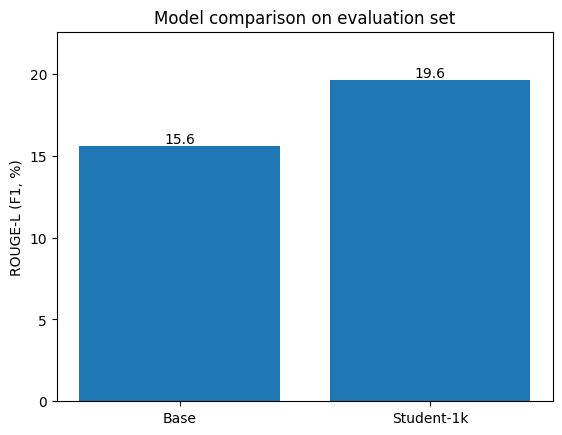

{'Base': 0.15594989694570874, 'Student-1k': 0.1962507859919638}


In [21]:
# >>> YOUR CODE HERE <<<
import matplotlib.pyplot as plt

def _pick_rougeL(scores: dict) -> float:
    
    if "rougeL" in scores:
        return float(scores["rougeL"])
    if "rougeLsum" in scores:
        return float(scores["rougeLsum"])
    raise KeyError("Neither 'rougeL' nor 'rougeLsum' found in scores dict.")

# compare
labels, values = [], []
if "rand_scores" in globals():
    labels = ["Random-1k", "Student-1k"]
    values = [_pick_rougeL(rand_scores), _pick_rougeL(stud_scores)]
elif "random_scores" in globals():
    labels = ["Random-1k", "Student-1k"]
    values = [_pick_rougeL(random_scores), _pick_rougeL(stud_scores)]
else:
    labels = ["Base", "Student-1k"]
    values = [_pick_rougeL(base_scores), _pick_rougeL(stud_scores)]

# convert to percentage
values_pct = [v * 100.0 for v in values]

plt.figure()
plt.bar(labels, values_pct)
for i, v in enumerate(values_pct):
    plt.text(i, v, f"{v:.1f}", ha="center", va="bottom")
plt.ylabel("ROUGE-L (F1, %)")
plt.title("Model comparison on evaluation set")
plt.ylim(0, max(values_pct) * 1.15 if values_pct else 1.0)
plt.show()

print({labels[i]: values[i] for i in range(len(labels))})
# raise NotImplementedError("Plot a bar chart comparing ROUGE-L across Random/Student.")